In [1]:
# Further restructure of program into functions + refinement of data structure(s) for model
    # Classifiction vs regression for new S/R level output (predicted S/R vs actual - needs to be calculated)
        # May be able to use multivariate regression for new/predicted S/R output as values instead of classes
        # If classification: One hot encoding into function  
            # Invert function for reversal of encoding and one-hot
        # Function for variable LSTM/GRU reshapeing
    # Model load/save to disk
        

In [2]:
# Imports
import pandas as pd
import numpy as np
import requests
import json
from json import loads
import datetime 
import matplotlib.pyplot as plt
%matplotlib inline
import time

# Charting-specific imports
import matplotlib.finance
import matplotlib.ticker as ticker
from matplotlib.finance import candlestick_ohlc,candlestick2_ohlc
from matplotlib.finance import volume_overlay,volume_overlay2
from matplotlib.dates import  DateFormatter, epoch2num
    # https://matplotlib.org/api/finance_api.html#module-matplotlib.finance

# API-specific imports (local install)
import gdax
    # Python setup.py install with environment activaated to install/use
    # Do not use default gdax pip install package - that version of the package is currently broken

# Pymongo import for connection to local client DB
import pymongo
from pymongo import MongoClient

# Preprocessing Imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from keras.utils import to_categorical 

# ML Imports 
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import Embedding, Flatten
from keras.layers import LSTM, GRU
from keras.models import load_model
from keras.models import model_from_json
from keras import backend as K

# autoSR() import requirements
from sklearn.cluster import MeanShift, estimate_bandwidth
from pandas_datareader import data, wb

###########################################################################
### Force Keras/TF to use CPU backend when GPU present by setting:
    # {'CPU' : 1, 'GPU' : 0}
    
#num_cores = 4
#config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,\
        #inter_op_parallelism_threads=num_cores, allow_soft_placement=True,\
        #device_count = {'CPU' : 1, 'GPU' : 1})
#session = tf.Session(config=config)
#K.set_session(session)
###########################################################################

# Import to check check for GPU availability for tensorflow backend
from tensorflow.python.client import device_lib

# Verify GPU availability for tensorflow backend
print(device_lib.list_local_devices())
print("==============================================")
print(K.tensorflow_backend._get_available_gpus())

C:\Users\tyu-dev\Anaconda3\envs\pythondata\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the module mpl_finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\tyu-dev\Anaconda3\envs\pythondata\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16075616223069260480
]
[]


In [3]:
# Global variables

# Boolean to drop existing mongo collection/scrape upon scrape() init
dropFlag = False

# Boolean to set size_delta to l2update values for first update to snapshot
#firstUpdate = False
firstUpdate_bids = False
firstUpdate_asks = False

# Value to track if feature_creation_inital() was run
feature_creation_intital_run = False

In [4]:
# Connection establishment

# Establish connection to GDAX public endpoint
public_client = gdax.PublicClient()

# Mongo database and collection specification:
mongo_client = MongoClient('mongodb://localhost:27017/')
db = mongo_client.btcusd_db
btcusd_collection = db.btcusd_collection

In [5]:
# Function to start scrape process from websocket to mongodb instance
def scrape_start():
    
    # Drop existing collection from db if dropFlag == True (on new scrape):
    if 'btcusd_db' in mongo_client.database_names() and dropFlag is True:
        mongo_client['btcusd_db'].drop_collection('btcusd_collection')
        #print(mongo_client.database_names())
        #print(db.collection_names())
        
    # Start instance of websocket client for L2 Orderbook + L2 update data request and scrape
    wsClient = gdax.WebsocketClient(url="wss://ws-feed.gdax.com", 
                                products=["BTC-USD"],\
                                message_type="subscribe",\
                                channels =["level2"],\
                                mongo_collection=btcusd_collection,\
                                should_print=False)
    
    # Save request open time and start websocket
    time.sleep(4)
    request_time_start=public_client.get_time()
    wsClient.start()
    
    # scrape_time is variable for time between websocket connection start and end
        # Defined in seconds
        # i.e. 600 seconds = scrape running for 10 minutes
    scrape_time = 600

    time.sleep(scrape_time)
    # Save request close time and close websocket
    request_time_end=public_client.get_time()
    wsClient.close()
    
    # Append request times for open/close of websocket stream to dataframe, save to csv
    request_log_df = pd.DataFrame.from_dict({'request start':request_time_start,'request end':request_time_end},orient ='index')
    request_log_df.to_csv("raw_data/request_log.csv",header=True,encoding='utf-8',index =True)

# Function to load and parse data from Mongo into dataframes
def load_parse():
    
    #Collection specification (in database)
    input_data = db.btcusd_collection 
    
    # Create individual dataframes for main response types: snapshot, l2update
    snapshot = pd.DataFrame(list(input_data.find({'type':'snapshot'})))
    l2update = pd.DataFrame(list(input_data.find({'type':'l2update'})))
    
    ### snapshot  response load and parse ###
    
    # Extract asks/bid individual column of array of arrays into lists
    snapshot_asks = snapshot[['asks'][0]][0]
    snapshot_bids = snapshot[['bids'][0]][0]
    
    # Convert list (of array of arrays) into dataframe
    snapshot_asks_df =pd.DataFrame(snapshot_asks)
    snapshot_bids_df =pd.DataFrame(snapshot_bids)
    
    # Rename columns to snapshot array format:
        # snapshot array format: [price, size]
            # [side, price, size] format for one-hot encoding
        # Ask = sell price, bid = buy price
    snapshot_asks_df.rename(columns ={0:'price',1:'size'}, inplace =True)
    snapshot_bids_df.rename(columns ={0:'price',1:'size'}, inplace =True)
    snapshot_asks_df['side'] = "sell"
    snapshot_bids_df['side'] = "buy"
    cols =['side','price','size']
    snapshot_asks_df = snapshot_asks_df[cols]
    snapshot_bids_df = snapshot_bids_df[cols]
    
    ### L2 update response load and parse ###
    
    # Restucture l2update to have [side,price,size] from 'changes' column
    l2update_clean = l2update[['changes','time']]
          
    # Convert changes list of lists -> into array 
    l2_array = np.ravel(l2update_clean['changes']) 
    # Flatten the list and remove outer bracket:
    flattened = [val for sublist in l2_array for val in sublist]
        # Reference: https://stackoverflow.com/questions/11264684/flatten-list-of-lists?
    # Convert back to dataframe and combine with timestamps from l2update:
    changes_df= pd.DataFrame.from_records(flattened)
    # Add time column back to L2 update dataframe
    l2update_formatted = pd.concat([changes_df,l2update_clean['time']],1)
    # Rename columns for [side, price, size]:
    l2update_formatted.rename({0:"side",1:"price",2:"size"}, axis ='columns',inplace=True)
    
    # Save parsed data to csv (API -> Mongo -> Dataframe -> .csv)
    #save_csv()
    
     # Save data to .csv format in raw_data folder
    l2update_formatted.to_csv("raw_data/l2update.csv",header=True,encoding='utf-8',index =False)
    snapshot_asks_df.to_csv("raw_data/snapshot_asks.csv",header=True,encoding='utf-8',index =False)
    snapshot_bids_df.to_csv("raw_data/snapshot_bids.csv",header=True,encoding='utf-8',index =False)

In [6]:
###########################################################################

# Section to read in data from csv (definition scope of functions above not working for assignment:)
    # Load in test data for development/debugging
    
# Read in data from raw_data folder instead of test_data folder
    # raw_data folder has 1hr of scraped data (snapshot + l2 response updates)
    # test_data folder only has 10 minutes of scraped data 
    
snapshot_asks_df = pd.read_csv("raw_data/snapshot_asks.csv",dtype ={'size':float,'size_delta':float})
snapshot_bids_df = pd.read_csv("raw_data/snapshot_bids.csv",dtype ={'size':float,'size_delta':float})
l2update_df = pd.read_csv("raw_data/l2update.csv", dtype ={'size':float})
request_log_df= pd.read_csv("raw_data/request_log.csv")

###########################################################################

In [7]:
##### Request 15minute chart data #####

#def chart_15m_request(request_log_df):

request_start = request_log_df['iso'][1]
request_end = request_log_df['iso'][0]

# Request 15 minutes of candlestick (open high low close) data from API
    # start time must be in ISO 8601 format for get_product_historic_rates()
chart_15m = public_client.get_product_historic_rates('BTC-USD', start = request_start, granularity=60)

# Convert chart data response into dataframes
chart_15m_df =pd.DataFrame.from_records(chart_15m,columns=["time","low", "high","open" ,"close", "volume"])

# Reorder columns according to label order required by matplotlib finance package
chart_15m_df = chart_15m_df[["time","open","high","low","close","volume"]]

# Reverse/sort timestamp order (without reversal chart labels/axis will be out of order)
chart_15m_df.sort_values(by='time',axis=0, inplace =True)

#Convert/sort time to datetime object (for matplotlib chart format requirement)
chart_15m_df['time'] =pd.to_datetime(chart_15m_df['time'],unit='s')  
    

In [476]:
# Auto support/resistance adapted into function 
    # Using estimate_bandwidth and meanshift() from sklearn.cluster library
    # Source: Adapted from https://github.com/nakulnayyar/SupResGenerator
    # Takes dataframe object with open/high/low/close values 
        # Returns list of auto-generated support and resistance levels for price action
def autoSR(dataframe):
    data = chart_15m_df.as_matrix(columns=['close'])
    data2 = data[:len(data)*1]
    bandwidth = estimate_bandwidth(data2, quantile=0.1, n_samples=100)
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms.fit(data2)
    ml_results = []
    for k in range(len(np.unique(ms.labels_))):
            my_members = ms.labels_ == k
            values = data[my_members, 0]    
            ml_results.append(min(values))
            ml_results.append(max(values))
            # Remove duplicate S/R level values
            # Using sets
            ml_set =set(ml_results)
            ml_results = list(ml_set)
            # Sort values before return output 
            ml_results.sort()
            
    return ml_results

def generate_chart(dataframe):
    
    dataframe = chart_15m_df 
    
    # Generate chart of past 15 minutes with autogenerated support and resistance levels:
    fig, ax = plt.subplots(figsize=(20, 10)
                         )
    candlestick2_ohlc(ax,chart_15m_df['open'],chart_15m_df['high'],chart_15m_df['low'],chart_15m_df['close'],width=2,\
                      colorup='k',colordown='r',alpha=.5)
    ax.set_xticklabels(chart_15m_df['time'] ,rotation=30)
    
    ax.xaxis.set_major_locator(ticker.MaxNLocator(17))
        # n + 2 for proper labe set at 20,18 chart size
        # 15 + 2 =17
    plt.yticks(np.arange(int(min(chart_15m_df['low'])-5), max(chart_15m_df['high'])+10, 5))
    plt.xlabel('Time')
    plt.ylabel('Price (USD)')
    #ax.minorticks_on()
    ax.set_axisbelow(True)
    ax.tick_params(axis='y', pad=10)
    ax.grid(which='major', linestyle='--', linewidth='0.1', color='b')
    matplotlib.pyplot.title("15 Min BTC/USD with Support/Resistance Levels")
    
   
    ml_results = autoSR(chart_15m_df)
    
    # Convert ml_results into sorted int array
    ml_results_modified =np.asarray(ml_results)
    ml_results_modified =np.trunc(ml_results_modified).astype(int)
    ml_results_modified = np.sort(ml_results_modified,kind = 'quicksort') 
    # Remove duplicates from int conversion
    ml_results_modified_set=set(ml_results_modified)
    ml_results_modified = list(ml_results_modified_set)
    ml_results_modified = np.sort(ml_results_modified,kind = 'quicksort')
    ml_results_modified
    
    # Add S/R labels to left side of chart
    count = 1
    for k in ml_results_modified:
        
        #count = count+ 2.12
        ax.axhline(y=k)
        #time?
        if count%3 == 0:
            plt.text(y=k,s=k,x=count,color='blue',rotation=45)
        count = count +1 
    plt.tight_layout()
    return plt.show()
    #return plt.show(), ml_results

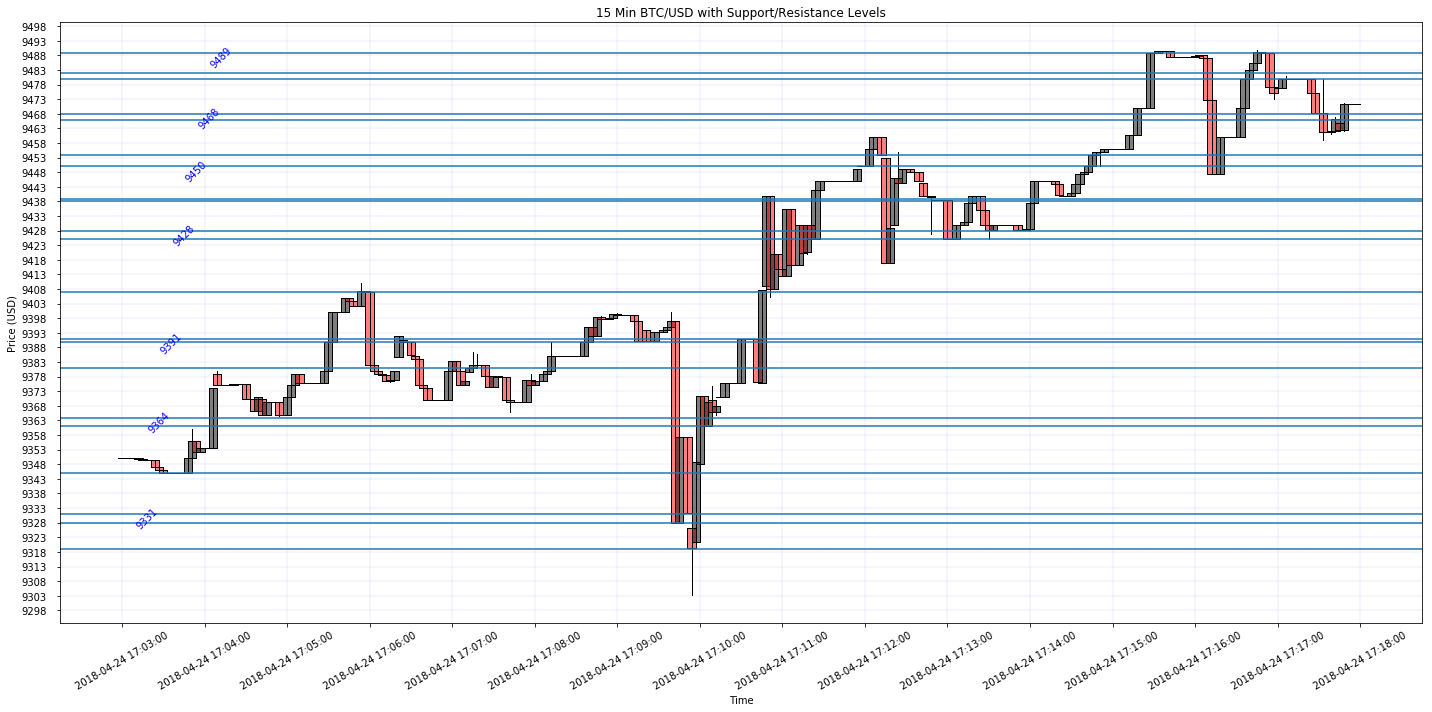

In [477]:
generate_chart(chart_15m_df)

In [10]:
# create and set inital/placeholder values for size_delta, position, and sr_prox_value/line input features 
    # run once upon new scrape only
def feature_creation_inital():
    #global feature_creation_intital_run
    
    #if feature_creation_inital_run() == False:
        #global feature_creation_intital_run
        
        
        
    # Set inital size delta l2 snapshot - use decimal point to force as float
    snapshot_asks_df['size_delta'] = 0.0
    snapshot_bids_df['size_delta'] = 0.0

    # Set inital position for l2 snapshot
    snapshot_asks_df['position'] = snapshot_asks_df.index +1
    snapshot_bids_df['position'] = snapshot_bids_df.index +1

    # Reverse index for sell/asks
    # snapshot_asks_df =snapshot_asks_df[::-1]
    # Reverse inital position indicator for bids/buy side
    rev = snapshot_bids_df['position'].values * -1
    snapshot_bids_df['position'] = rev

    # Set inital proximity value and inital value for nearest prox line
    snapshot_asks_df['sr_prox_value'] = 0
    snapshot_asks_df['sr_prox_line'] = 0
    snapshot_bids_df['sr_prox_value'] = 0
    snapshot_bids_df['sr_prox_line'] = 0

    # Set feature_creation_inital_run flag to True once run
    feature_creation_inital_run = True
        
        
        
    #elif feature_creation_inital_run == True:
        #global feature_creation_intital_run
        # Required syntax for logical operator/ if-else structure, but does nothing as a result
        # i.e., a "pass"
        
        #print("pass")
        #pass

In [11]:
# L2 update states applied to snapshot over a defined interval (15m, in sync with chart update)
    # Applied to both snapshot_bids_df and snapshot_asks_df
    # Must be run before sr_update()
def l2_state_update():
    
    global firstUpdate_bids 
    global firstUpdate_asks
    
    for i in range(len(snapshot_bids_df)):

        # If size in l2update_df is 0, remove that row/price point from the orderbook state
        if l2update_df['size'].values[i] == 0:
            #print (snapshot_bids_df['price'].values[i])
            snapshot_bids_df.drop(snapshot_bids_df.index[i])

        #First update to snapshot, set 'size_delta' to l2update values
            # Note: Keep here or move to end of feature_creation_inital depending on execution order
        elif l2update_df['size'].values[i] != 0 & firstUpdate_bids == False:
            snapshot_bids_df['size_delta'].values[i] = l2update_df['size'].values[i]
            firstUpdate_bids = True
        #Subsequent size delta calc
        elif l2update_df['size'].values[i] != 0:
            currentsize =snapshot_bids_df['size'].values[i] 
            updatesize = l2update_df['size'].values[i]
            snapshot_bids_df['size_delta'].values[i] = updatesize-currentsize

        # Update positional values for bids snapshot
        snapshot_bids_df['position'] = snapshot_bids_df.index + 1
        rev = snapshot_bids_df['position'].values * -1
        snapshot_bids_df['position'] = rev 

    for i in range(len(snapshot_asks_df)):

        # If size in l2update_df is 0, remove that row/price point from the orderbook state
        if l2update_df['size'].values[i] == 0:
            #print (snapshot_asks_df['price'].values[i])
            snapshot_asks_df.drop(snapshot_asks_df.index[i])

        #First update to snapshot, set 'size_delta' to l2update values
            # Note: Keep here or move to end of feature_creation_inital depending on execution order
        elif l2update_df['size'].values[i] != 0 & firstUpdate_asks == False:
            snapshot_asks_df['size_delta'].values[i] = l2update_df['size'].values[i]
            firstUpdate_asks = True
        #Subsequent size delta calc
        elif l2update_df['size'].values[i] != 0:
            currentsize =snapshot_asks_df['size'].values[i] 
            updatesize = l2update_df['size'].values[i]
            snapshot_asks_df['size_delta'].values[i] = updatesize-currentsize

        # Update positional values for_asks snapshot
        snapshot_asks_df['position'] = snapshot_asks_df.index + 1
        #rev = snapshot_asks_df['position'].values * -1
        #snapshot_asks_df['position'] = rev 

In [12]:
# Function to update sr_prox_line and sr_prox_value between orderbook states
    # Note: l2_state_update applied first, then sr_update(); switch order if linear calls or switch execution block cell
    # Must be run before model input in sequence
def sr_update():
    
    # Convert to array for loop value traversal        
    ml_results_modified_array = np.array(ml_results_modified)

    ### snapshot_asks sr_prox_line,sr_prox_value set ###
    for i in range(len(snapshot_asks_df['price'])):
        #if snapshot_asks_df['price'].values[i] in ml_results_modified: 
            priceInt = int(snapshot_asks_df['price'].values[i])
            diff =abs(ml_results_modified - priceInt)
            diff_array = np.array(diff)
            lowest_abs =min(diff)
            #print("=============================")
            #print("Price: ")
            #print(snapshot_asks_df['price'].values[i])
            #print("Diff:")
            #print(diff)
            #print("lowest_abs value: ")
            #print(lowest_abs)
            minIndex= list(diff_array).index(lowest_abs)
            #print("Closest S/R line:")
            #print(ml_results_modified[minIndex])
            #print("=============================")

            #Set sr_prox_value to distance from closest S/R line
            snapshot_asks_df['sr_prox_value'].values[i] = lowest_abs
            #Set sr_prox_line value
            snapshot_asks_df['sr_prox_line'].values[i] = ml_results_modified[minIndex]

    ### snapshot_bids sr_prox_line,sr_prox_value set ###
    for i in range(len(snapshot_bids_df['price'])):
        #if snapshot_bids_df['price'].values[i] in ml_results_modified: 
            priceInt = int(snapshot_bids_df['price'].values[i])
            diff =abs(ml_results_modified - priceInt)
            diff_array = np.array(diff)
            lowest_abs =min(diff)
            #print("=============================")
            #print("Price: ")
            #print(snapshot_bids_df['price'].values[i])
            #print("Diff:")
            #print(diff)
            #print("lowest_abs value: ")
            #print(lowest_abs)
            minIndex= list(diff_array).index(lowest_abs)
            #print("Closest S/R line:")
            #print(ml_results_modified[minIndex])
            #print("=============================")

            #Set sr_prox_value to distance from closest S/R line
            snapshot_bids_df['sr_prox_value'].values[i] = lowest_abs
            #Set sr_prox_line value
            snapshot_bids_df['sr_prox_line'].values[i] = ml_results_modified[minIndex]

In [13]:
###########################################################################
###########################################################################
###########################################################################


# Debugging:

In [14]:
# Assignment of ml_results from function:
ml_results = autoSR(chart_15m_df)
autoSR(chart_15m_df)

[9319.23,
 9328.01,
 9331.18,
 9345.0,
 9361.24,
 9364.99,
 9381.01,
 9381.97,
 9390.9,
 9391.95,
 9407.0,
 9407.5,
 9425.01,
 9428.1,
 9438.63,
 9439.43,
 9450.0,
 9454.0,
 9466.36,
 9468.32,
 9480.02,
 9482.89,
 9489.62]

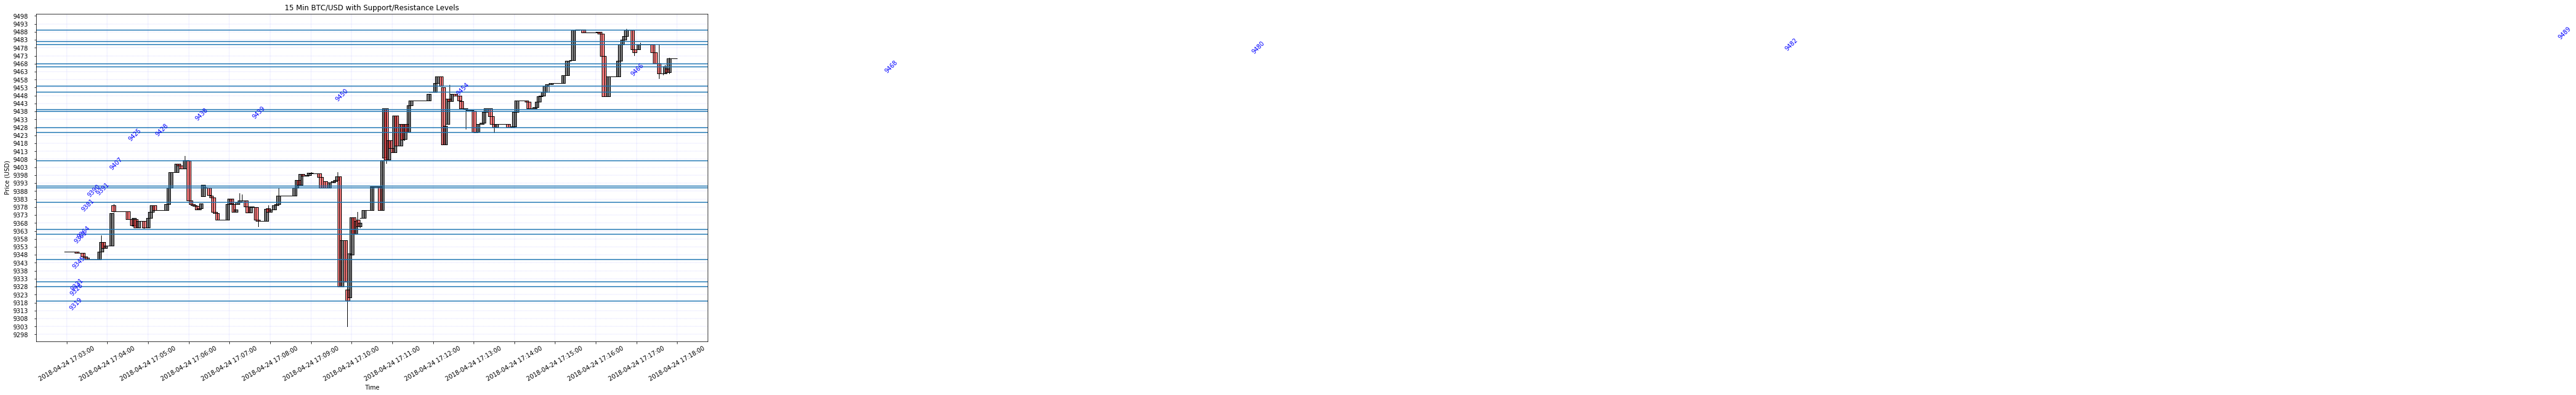

In [15]:
generate_chart(chart_15m_df)

In [16]:
# Data structures for scrape/request log and support/resistance (predicted vs actual)
    # request start, request end
    # current s/r levels: chart 15m data + ml_results (actual)
    # predicted s/r levels: ml_results (predicted)
    # current s/r levels vs predicted for current timeframe (training vs testing)

# Convert ml_results into sorted int array
ml_results_modified =np.asarray(ml_results)
ml_results_modified =np.trunc(ml_results_modified).astype(int)
ml_results_modified = np.sort(ml_results_modified,kind = 'quicksort') 
# Remove duplicates from int conversion
ml_results_modified_set=set(ml_results_modified)
ml_results_modified = list(ml_results_modified_set)
ml_results_modified = np.sort(ml_results_modified,kind = 'quicksort')
ml_results_modified

array([9319, 9328, 9331, 9345, 9361, 9364, 9381, 9390, 9391, 9407, 9425,
       9428, 9438, 9439, 9450, 9454, 9466, 9468, 9480, 9482, 9489])

In [17]:
###########################################################################

# Create inital features for snapshot_asks_df
    # feature_creation_inital()
# Apply first L2 state update to snapshot
    # l2_state_update()
# Update/apply sr_prox_value and sr_prox_line to updated snapshot
    # sr_update()
    
feature_creation_inital()
l2_state_update()
sr_update()

# Information about snapshot_asks_df for:
    # input shape information 
    # and to verify that the above three functions were applied
snapshot_asks_df.head()

,side,price,size,size_delta,position,sr_prox_value,sr_prox_line
0,sell,9192.01,4.660822,0.0100,1,127,9319
1,sell,9194.95,1.086830,0.0015,2,125,9319
2,sell,9194.99,0.001500,0.0000,3,125,9319
3,sell,9195.00,2.061000,0.0000,4,124,9319
4,sell,9195.01,2.463947,0.0015,5,124,9319


In [18]:
# Results for predicted S/R levels may vary in total element/array length
    # But will still be array similar in shape to the below 
    # Length may vary slightly between 15m intervals
ml_results_modified

array([9319, 9328, 9331, 9345, 9361, 9364, 9381, 9390, 9391, 9407, 9425,
       9428, 9438, 9439, 9450, 9454, 9466, 9468, 9480, 9482, 9489])

In [19]:
# Length of ml_results_modified (for this specific 15m run/request at this point in time)
np.size(ml_results_modified)

21

In [256]:
###### One-hot encoding if using classification/classes for target variable (y)

# Cat+ One hot encoding if using sr_prox_line column as target classes
data = snapshot_asks_df.values
X = data[:,1:6]
y = data[:,6:7]
y = np.ravel(y)
label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(y)
onehot_encoder = OneHotEncoder(sparse=False)
encoded_y = encoded_y.reshape(len(encoded_y), 1)
onehot_y = onehot_encoder.fit_transform(encoded_y)

In [295]:
onehot_y

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [296]:
encoded_y

array([[ 0],
       [ 0],
       [ 0],
       ...,
       [20],
       [20],
       [20]], dtype=int64)

In [257]:
# Shape information for input shaping
print(data.shape)
print("Shape without side column :")
print(X.shape)
print(y.shape)
print(onehot_y.shape)

(14078, 7)
Shape without side column :
(14078, 5)
(14078,)
(14078, 21)


In [258]:
# Reshape X into format required for LSTM/GRU input:

print(X.shape)
Xshapetest = np.reshape(X, (X.shape[0], 1, X.shape[1]))
print(Xshapetest.shape)

(14078, 5)
(14078, 1, 5)


In [259]:
Xshapetest.shape[0]

14078

In [260]:
print(onehot_y.shape)

(14078, 21)


In [74]:
# Command to reset state of each LSTM layer
model.reset_states()

In [261]:
### Model construction ###

data_dim = Xshapetest.shape[2]
    # Features
timesteps = Xshapetest.shape[1]
    # Timesteps
batch_size = Xshapetest.shape[0]
    # required parameter for LSTM if stateful = True
    # Size of entire batch or batch sizes
    
#1024,512,256 --> when using GPU
#50, 25, 10 --> when using CPU-only 

model = Sequential()
model.add(LSTM(50, return_sequences=True, stateful=True,
               batch_input_shape=(batch_size , timesteps, data_dim )))
                                                #input_shape(batch_size, timesteps,features)
                                                #input_shape(timesteps,features)
model.add(LSTM(25, return_sequences=True,stateful=True ))
model.add(LSTM(10, return_sequences=False,stateful=True ))
#model.add(Dropout(dropout),0.2)
#model.add(LSTM(128, return_sequences=True,stateful=True ))
#model.add(LSTM(64, return_sequences=False,stateful=True ))
#model.add(LSTM(64, return_sequences=False,stateful=True ))
model.add(Dense(onehot_y.shape[1], activation='relu'))
#model.add(Dense(1, activation='relu'))
model.compile(loss = "categorical_crossentropy", optimizer = 'rmsprop', metrics = ['accuracy'])
#model.compile(loss = "logcosh", optimizer = 'adam', metrics = ['accuracy'])
model.summary() 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_48 (LSTM)               (14078, 1, 50)            11200     
_________________________________________________________________
lstm_49 (LSTM)               (14078, 1, 25)            7600      
_________________________________________________________________
lstm_50 (LSTM)               (14078, 10)               1440      
_________________________________________________________________
dense_43 (Dense)             (14078, 21)               231       
Total params: 20,471
Trainable params: 20,471
Non-trainable params: 0
_________________________________________________________________


In [262]:
model.fit(
    Xshapetest,
    onehot_y, 
    epochs=10,
    shuffle=False, #Set shuffle to false when stateful = True in model definition above
    verbose=2,
    batch_size=batch_size  #validation_data=(X, onehot_y)
)

Epoch 1/10
 - 3s - loss: 5.0182 - acc: 0.0026
Epoch 2/10
 - 0s - loss: 2.8106 - acc: 0.2879
Epoch 3/10
 - 0s - loss: 2.0960 - acc: 0.7455
Epoch 4/10
 - 0s - loss: 1.8807 - acc: 0.8757
Epoch 5/10
 - 0s - loss: 1.7745 - acc: 0.9168
Epoch 6/10
 - 0s - loss: 1.7002 - acc: 0.9293
Epoch 7/10
 - 0s - loss: 1.6372 - acc: 0.9416
Epoch 8/10
 - 0s - loss: 1.5776 - acc: 0.9428
Epoch 9/10
 - 0s - loss: 1.5217 - acc: 0.9440
Epoch 10/10
 - 0s - loss: 1.4706 - acc: 0.9440


In [263]:
### Examination of results for model interpretation ###

# Examination of predicted classes if using one-hot encoding

model.predict_classes(Xshapetest,batch_size=batch_size)
b = model.predict_classes(Xshapetest,batch_size=batch_size)
print(np.unique(b))

[ 0  1  2  4  5 20]


In [294]:
# Breakout of model.predict results into dataframe for examination:
#pd.set_option('display.expand_frame_repr', True

pd.options.display.width = None
a =model.predict(Xshapetest,batch_size=batch_size)
#ab = pd.get_dummies(Xshapetest)
a_df = pd.DataFrame(a)
a_df.head(15)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.224841,0.0,0.0,0.133695,0.162338,0.0,0.100861,0.168754,0.0,0.05748,...,0.0,0.021349,0.0,0.046826,0.038992,0.117923,0.049737,0.0,0.009873,0.0
1,0.224841,0.0,0.0,0.133695,0.162338,0.0,0.100861,0.168754,0.0,0.05748,...,0.0,0.021349,0.0,0.046826,0.038992,0.117923,0.049737,0.0,0.009873,0.0
2,0.224841,0.0,0.0,0.133695,0.162338,0.0,0.100861,0.168754,0.0,0.05748,...,0.0,0.021349,0.0,0.046826,0.038992,0.117923,0.049737,0.0,0.009873,0.0
3,0.224841,0.0,0.0,0.133695,0.162338,0.0,0.100861,0.168754,0.0,0.05748,...,0.0,0.021349,0.0,0.046826,0.038992,0.117923,0.049737,0.0,0.009873,0.0
4,0.224841,0.0,0.0,0.133695,0.162338,0.0,0.100861,0.168754,0.0,0.05748,...,0.0,0.021349,0.0,0.046826,0.038992,0.117923,0.049737,0.0,0.009873,0.0
5,0.224841,0.0,0.0,0.133695,0.162338,0.0,0.100861,0.168754,0.0,0.05748,...,0.0,0.021349,0.0,0.046826,0.038992,0.117923,0.049737,0.0,0.009873,0.0
6,0.224841,0.0,0.0,0.133695,0.162338,0.0,0.100861,0.168754,0.0,0.05748,...,0.0,0.021349,0.0,0.046826,0.038992,0.117923,0.049737,0.0,0.009873,0.0
7,0.224841,0.0,0.0,0.133695,0.162338,0.0,0.100861,0.168754,0.0,0.05748,...,0.0,0.021349,0.0,0.046826,0.038992,0.117923,0.049737,0.0,0.009873,0.0
8,0.224841,0.0,0.0,0.133695,0.162338,0.0,0.100861,0.168754,0.0,0.05748,...,0.0,0.021349,0.0,0.046826,0.038992,0.117923,0.049737,0.0,0.009873,0.0
9,0.224841,0.0,0.0,0.133695,0.162338,0.0,0.100861,0.168754,0.0,0.05748,...,0.0,0.021349,0.0,0.046826,0.038992,0.117923,0.049737,0.0,0.009873,0.0


In [306]:
model.predict_classes(Xshapetest,batch_size=batch_size)
b = model.predict_classes(Xshapetest,batch_size=batch_size)
print(np.unique(b))

[ 0  1  4  5 11 20]


In [307]:
b_df = pd.DataFrame(b)
b_df

,0
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


In [265]:
# axis : {index (0), columns (1)}
a_df.max(axis=0)

0     0.217939
1     0.109860
2     0.182569
3     0.131043
4     0.158911
5     0.141911
6     0.160759
7     0.164181
8     0.061984
9     0.190237
10    0.057394
11    0.096833
12    0.150918
13    0.104886
14    0.062933
15    0.060267
16    0.112870
17    0.210043
18    0.077333
19    0.059980
20    0.430994
dtype: float32

In [186]:
a_df.max(axis=1)

0        0.293409
1        0.305955
2        0.309209
3        0.304270
4        0.303406
5        0.329062
6        0.301371
7        0.296165
8        0.290682
9        0.284217
10       0.279850
11       0.346785
12       0.264944
13       0.268140
14       0.301975
15       0.250312
16       0.246840
17       0.266298
18       0.246642
19       0.247630
20       0.250361
21       0.251937
22       0.255299
23       0.259609
24       0.264056
25       0.269740
26       0.276377
27       0.299086
28       0.275143
29       0.313038
           ...   
14048    0.264805
14049    0.264805
14050    0.264805
14051    0.264805
14052    0.264805
14053    0.264805
14054    0.264805
14055    0.264805
14056    0.264805
14057    0.264805
14058    0.264805
14059    0.264805
14060    0.264805
14061    0.264805
14062    0.264805
14063    0.264805
14064    0.264805
14065    0.264805
14066    0.264805
14067    0.264805
14068    0.264805
14069    0.264805
14070    0.264805
14071    0.264805
14072    0

In [266]:
print(np.unique(a))

[0.0000000e+00 9.8561868e-06 5.1984563e-05 ... 4.3099210e-01 4.3099284e-01
 4.3099371e-01]


In [267]:
a_df.sum(axis=1)

0        1.104079
1        1.104079
2        1.104079
3        1.104079
4        1.104079
5        1.104079
6        1.104079
7        1.104079
8        1.104079
9        1.104079
10       1.104079
11       1.104079
12       1.104079
13       1.104079
14       1.104079
15       1.104079
16       1.104079
17       1.104079
18       1.104079
19       1.104079
20       1.104079
21       1.104079
22       1.104079
23       1.104079
24       1.104079
25       1.104079
26       1.104079
27       1.104079
28       1.104079
29       1.104079
           ...   
14048    0.330996
14049    0.330996
14050    0.330996
14051    0.330996
14052    0.330996
14053    0.330996
14054    0.330996
14055    0.330996
14056    0.330996
14057    0.330996
14058    0.330996
14059    0.330996
14060    0.330996
14061    0.330996
14062    0.330996
14063    0.330996
14064    0.330996
14065    0.330996
14066    0.330996
14067    0.330996
14068    0.330996
14069    0.330996
14070    0.330996
14071    0.330996
14072    0

In [268]:
a_df.sum(axis=0)

0     195.13...
1     18.422173
2     937.99...
3     117.38...
4     151.62...
5     24.817329
6     336.10...
7     144.95...
8     26.510218
9     1151.2...
10    15.842749
11    101.45...
12    857.99...
13    473.66...
14    41.503681
15    65.904289
16    105.31...
17    1964.2...
18    17.921160
19    19.696732
20    4623.6...
dtype: float32

In [269]:
inverted

array([9319, 9319, 9319, ..., 9489, 9489, 9489], dtype=object)

In [270]:
# Remove duplicate price points from inverted list
inverted_set=set(inverted)
inverted_list = list(inverted_set)
inverted_modified = np.sort(inverted_list,kind = 'quicksort')
inverted_modified

array([9319, 9328, 9331, 9345, 9361, 9364, 9381, 9390, 9391, 9407, 9425,
       9428, 9438, 9439, 9450, 9454, 9466, 9468, 9480, 9482, 9489])

In [271]:
# Check size/length
print(np.size(inverted_modified))

21


In [290]:
# Set column names back to pre categorical/non one-hot encoding
a_df.columns = inverted_modified
#a_df['price'] = snapshot_asks_df['price']
a_df.index = snapshot_asks_df['price']
a_df.head(15)

,9319,9328,9331,9345,9361,9364,9381,9390,9391,9407,...,9428,9438,9439,9450,9454,9466,9468,9480,9482,9489
price,,,,,,,,,,,,,,,,,,,,,
9192.01,0.217939,0.0,0.0,0.131043,0.158911,0.0,0.100638,0.164181,0.0,0.058914,...,0.0,0.022462,0.0,0.044689,0.035498,0.11287,0.049244,0.0,0.00769,0.0
9194.95,0.217939,0.0,0.0,0.131043,0.158911,0.0,0.100638,0.164181,0.0,0.058914,...,0.0,0.022462,0.0,0.044689,0.035498,0.11287,0.049244,0.0,0.00769,0.0
9194.99,0.217939,0.0,0.0,0.131043,0.158911,0.0,0.100638,0.164181,0.0,0.058914,...,0.0,0.022462,0.0,0.044689,0.035498,0.11287,0.049244,0.0,0.00769,0.0
9195.00,0.217939,0.0,0.0,0.131043,0.158911,0.0,0.100638,0.164181,0.0,0.058914,...,0.0,0.022462,0.0,0.044689,0.035498,0.11287,0.049244,0.0,0.00769,0.0
9195.01,0.217939,0.0,0.0,0.131043,0.158911,0.0,0.100638,0.164181,0.0,0.058914,...,0.0,0.022462,0.0,0.044689,0.035498,0.11287,0.049244,0.0,0.00769,0.0
9196.00,0.217939,0.0,0.0,0.131043,0.158911,0.0,0.100638,0.164181,0.0,0.058914,...,0.0,0.022462,0.0,0.044689,0.035498,0.11287,0.049244,0.0,0.00769,0.0
9196.01,0.217939,0.0,0.0,0.131043,0.158911,0.0,0.100638,0.164181,0.0,0.058914,...,0.0,0.022462,0.0,0.044689,0.035498,0.11287,0.049244,0.0,0.00769,0.0
9196.02,0.217939,0.0,0.0,0.131043,0.158911,0.0,0.100638,0.164181,0.0,0.058914,...,0.0,0.022462,0.0,0.044689,0.035498,0.11287,0.049244,0.0,0.00769,0.0
9196.03,0.217939,0.0,0.0,0.131043,0.158911,0.0,0.100638,0.164181,0.0,0.058914,...,0.0,0.022462,0.0,0.044689,0.035498,0.11287,0.049244,0.0,0.00769,0.0


In [308]:
####################################################################################################################
####################################################################################################################
####################################################################################################################
####################################################################################################################


In [310]:
# Create test dataframe for binary value for S/R prediction test
snapshot_asks_df_test = snapshot_asks_df

In [309]:
def sr_update_binary():
    
    snapshot_asks_df_test['is_line'] = 0
    # Convert to array for loop value traversal        
    ml_results_modified_array = np.array(ml_results_modified)

    ### snapshot_asks sr_prox_line,sr_prox_value set ###
    for i in range(len(snapshot_asks_df_test['price'])):
        if snapshot_asks_df_test['price'].values[i] in ml_results_modified: 
            snapshot_asks_df_test['is_line'].values[i] = 1

In [311]:
snapshot_asks_df_test.head()

,side,price,size,size_delta,position,sr_prox_value,sr_prox_line
0,sell,9192.01,4.660822,0.0100,1,127,9319
1,sell,9194.95,1.086830,0.0015,2,125,9319
2,sell,9194.99,0.001500,0.0000,3,125,9319
3,sell,9195.00,2.061000,0.0000,4,124,9319
4,sell,9195.01,2.463947,0.0015,5,124,9319


In [312]:
sr_update_binary()

In [316]:
#Check to make sure above worked
#snapshot_asks_df_test['is_line' ==1]
snapshot_asks_df_test.loc[snapshot_asks_df_test['is_line' ] == 1]

,side,price,size,size_delta,position,sr_prox_value,sr_prox_line,is_line
569,sell,9319.0,0.001000,38.392352,570,0,9319,1
599,sell,9328.0,0.021000,0.000000,600,0,9328,1
612,sell,9331.0,0.001000,10.165699,613,0,9331,1
660,sell,9345.0,26.586341,0.001500,661,0,9345,1
707,sell,9361.0,0.001000,10.105329,708,0,9361,1
718,sell,9364.0,0.001000,4.465504,719,0,9364,1
777,sell,9381.0,0.001000,0.001794,778,0,9381,1
804,sell,9390.0,1.035400,0.536045,805,0,9390,1
809,sell,9391.0,5.473871,3.466264,810,0,9391,1
867,sell,9407.0,0.011000,0.010000,868,0,9407,1


In [323]:
# Cat+ One hot encoding if using sr_prox_line column as target classes
data2 = snapshot_asks_df.values
Xt = data2[:,1:7]
yt = data2[:,7:8]
yt = np.ravel(y)
label_encoder = LabelEncoder()
encoded_yt = label_encoder.fit_transform(yt)
onehot_encoder = OneHotEncoder(sparse=False)
encoded_yt = encoded_yt.reshape(len(encoded_yt), 1)
onehot_yt = onehot_encoder.fit_transform(encoded_yt)

In [324]:
yt

array([0, 0, 0, ..., 0, 0, 0], dtype=object)

In [325]:
print(Xt.shape)
Xshapetest2 = np.reshape(Xt, (Xt.shape[0], 1, Xt.shape[1]))
print(Xshapetest2.shape)

(14078, 6)
(14078, 1, 6)


In [369]:
### model4 construction ###

#embedding layer, variable input reshape layer, or limited samples to pass to model if stateful=True

from keras.layers import Dropout

data_dim = Xshapetest2.shape[2]
    # Features
timesteps = Xshapetest2.shape[1]
    # Timesteps
batch_size = Xshapetest2.shape[0]
    # required parameter for LSTM if stateful = True
    # Size of entire batch or batch sizes
    

model4 = Sequential()
model4.add(LSTM(50, return_sequences=True, stateful=True,
               batch_input_shape=(batch_size , timesteps, data_dim )))
                                                #input_shape(batch_size, timesteps,features)
                                                #input_shape(timesteps,features)
#model4.add(Dropout(0.5))
model4.add(LSTM(25, return_sequences=True,stateful=True ))
#model4.add(Dropout(0.5))
model4.add(LSTM(10, return_sequences=False,stateful=True ))
#model4.add(Dropout(0.5))
#model4.add(LSTM(128, return_sequences=True,stateful=True ))
#model4.add(LSTM(64, return_sequences=False,stateful=True ))
#model4.add(LSTM(64, return_sequences=False,stateful=True ))
model4.add(Dense(onehot_yt.shape[1], activation='relu'))
#model4.add(Dense(1, activation='relu'))
model4.compile(loss = "binary_crossentropy", optimizer = 'adam', metrics = ['accuracy'])
#model4.compile(loss = "logcosh", optimizer = 'adam', metrics = ['accuracy'])
model4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_91 (LSTM)               (14078, 1, 50)            11400     
_________________________________________________________________
lstm_92 (LSTM)               (14078, 1, 25)            7600      
_________________________________________________________________
lstm_93 (LSTM)               (14078, 10)               1440      
_________________________________________________________________
dense_56 (Dense)             (14078, 2)                22        
Total params: 20,462
Trainable params: 20,462
Non-trainable params: 0
_________________________________________________________________


In [370]:
model4.fit(
    Xshapetest2,
    onehot_yt, 
    epochs=25,
    shuffle=False, #Set shuffle to false when stateful = True in model definition above
    verbose=2,
    batch_size=batch_size,
    validation_data=(Xshapetest2, onehot_yt)
)

Train on 14078 samples, validate on 14078 samples
Epoch 1/25
 - 5s - loss: 2.3736 - acc: 0.5000 - val_loss: 1.6591 - val_acc: 0.5000
Epoch 2/25
 - 0s - loss: 1.4257 - acc: 0.5000 - val_loss: 1.1930 - val_acc: 0.5000
Epoch 3/25
 - 0s - loss: 1.0752 - acc: 0.5000 - val_loss: 0.9681 - val_acc: 0.5000
Epoch 4/25
 - 0s - loss: 0.9079 - acc: 0.5000 - val_loss: 0.8482 - val_acc: 0.5000
Epoch 5/25
 - 0s - loss: 0.8081 - acc: 0.5000 - val_loss: 0.7635 - val_acc: 0.5000
Epoch 6/25
 - 0s - loss: 0.7312 - acc: 0.5000 - val_loss: 0.6957 - val_acc: 0.5000
Epoch 7/25
 - 0s - loss: 0.6702 - acc: 0.5000 - val_loss: 0.6422 - val_acc: 0.5000
Epoch 8/25
 - 0s - loss: 0.6225 - acc: 0.5136 - val_loss: 0.5999 - val_acc: 0.5357
Epoch 9/25
 - 0s - loss: 0.5841 - acc: 0.5841 - val_loss: 0.5638 - val_acc: 0.6053
Epoch 10/25
 - 0s - loss: 0.5486 - acc: 0.6273 - val_loss: 0.5291 - val_acc: 0.6546
Epoch 11/25
 - 0s - loss: 0.5145 - acc: 0.6687 - val_loss: 0.4958 - val_acc: 0.7168
Epoch 12/25
 - 0s - loss: 0.4817 - 

In [371]:
model_loss, model_accuracy=model4.evaluate(Xshapetest2, onehot_yt,batch_size=batch_size)
print(f"Test model - Loss: {model_loss}, Accuracy: {model_accuracy}")

14078/14078 [==============================] - 0s 4us/step
Test model - Loss: 0.21323247253894806, Accuracy: 0.9306719899177551


In [381]:
model4.predict(Xshapetest2,batch_size=batch_size)
bt = model4.predict(Xshapetest2,batch_size=batch_size)
bt_df = pd.DataFrame(bt)
bt_df.index = snapshot_asks_df['price'].values

In [412]:
bt_df.head(15)


,0,1
9192.01,0.708347,0.035369
9194.95,0.708357,0.035370
9194.99,0.708359,0.035371
9195.00,0.708357,0.035370
9195.01,0.708356,0.035370
9196.00,0.708356,0.035371
9196.01,0.708357,0.035370
9196.02,0.708362,0.035371
9196.03,0.708362,0.035371
9196.04,0.708362,0.035371


In [413]:
print(np.unique(bt_df))

[0.0000000e+00 1.4331378e-04 3.0228682e-04 ... 8.2383412e-01 8.2383502e-01
 8.2383513e-01]


In [ ]:
####################################################################################################################
####################################################################################################################

In [171]:
#cols = list(a_df)
#cols.insert(0, cols.pop(cols.index('price')))
#a_df = a_df.loc[:, cols]
#a_df.head()

In [272]:
# Reversal of categoricial and onehot encoding (if needed)

decoded = onehot_y.dot(onehot_encoder.active_features_).astype(int)
#print(decoded)
inverted = label_encoder.inverse_transform(decoded)
inverted

C:\Users\tyu-dev\Anaconda3\envs\pythondata\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array([9319, 9319, 9319, ..., 9489, 9489, 9489], dtype=object)

In [273]:
snapshot_asks_df.head()

,side,price,size,size_delta,position,sr_prox_value,sr_prox_line
0,sell,9192.01,4.660822,0.0100,1,127,9319
1,sell,9194.95,1.086830,0.0015,2,125,9319
2,sell,9194.99,0.001500,0.0000,3,125,9319
3,sell,9195.00,2.061000,0.0000,4,124,9319
4,sell,9195.01,2.463947,0.0015,5,124,9319


In [ ]:
####################################################################################################################
####################################################################################################################
####################################################################################################################
####################################################################################################################
####################################################################################################################
####################################################################################################################

In [33]:
# Shaping/encoding for non-categorical encoding (multivariate regression)

In [ ]:
model2 = Sequential()
#model2.add(LSTM(25, return_sequences=False, stateful=False,
               #batch_input_shape=(batch_size , timesteps, data_dim )))
                                                #input_shape(batch_size, timesteps,features)
                                                #input_shape(timesteps,features)
model2.add(LSTM(200, return_sequences=True,
               input_shape=(timesteps, data_dim )))
model2.add(LSTM(50, return_sequences=False,stateful=False ))
#model2.add(LSTM(10, return_sequences=False,stateful=True ))
#model2.add(Dropout(dropout),0.2)
#model2.add(LSTM(128, return_sequences=True,stateful=True ))
#model2.add(LSTM(64, return_sequences=False,stateful=True ))
#model2.add(LSTM(64, return_sequences=False,stateful=True ))
model2.add(Dense(1, activation='sigmoid'))
#model2.add(Dense(1, activation='relu'))
model2.compile(loss = "mse", optimizer = 'adam', metrics = ['accuracy'])
#model2.compile(loss = "logcosh", optimizer = 'adam', metrics = ['accuracy'])
model2.summary() 

In [ ]:
# Scale y data if not one hot encoding (regression)
import sklearn.preprocessing
y_scaled=sklearn.preprocessing.scale(y)  
y_scaled

In [ ]:
model2.reset_states()

In [ ]:
model2.fit(
    Xshapetest,
    y, 
    epochs=10,
    shuffle=True, #Set shuffle to false when stateful = True in model definition above
    verbose=2,
    validation_data=(Xshapetest, y),
    batch_size = 100
    #batch_size=batch_size  #validation_data=(X, onehot_y)
)

In [ ]:
model_loss, model_accuracy=model2.evaluate(Xshapetest, y_scaled)
print(f"Test model - Loss: {model_loss}, Accuracy: {model_accuracy}")

In [ ]:
model3 = Sequential()
model3.add(Dense(units=1000, activation='relu', input_dim=4))
#model3.add(Dense(units=5, activation='sigmoid'))
#model3.add(Dropout(0.5))
#model3.add(Dense(units=50, activation='relu'))
model3.add(Dense(units=1, activation='relu'))

model3.compile(optimizer='adam', 
              loss='mse', 
              metrics=['accuracy'])
model3.summary()

In [ ]:
model3.fit(
    X,
    y_scaled, 
    epochs=25,
    shuffle=True, #Set shuffle to false when stateful = True in model definition above
    verbose=2,
    validation_data=(X, y_scaled),
    batch_size = 500
    #batch_size=batch_size  #validation_data=(X, onehot_y)
)

In [ ]:
### Model load and save ###
# Save compiled model and model layer weights to disk

#model_json = model.to_json()
#with open("model.json", "w") as json_file:
#json_file.write(model_json)
#model.save_weights("model.h5")

In [ ]:
# Load model from disk and model layer weights

#json_file = open('model/model.json', 'r')
#loaded_model_json = json_file.read()
#json_file.close()
#loaded_model = model_from_json(loaded_model_json)

# load weights into new model
#loaded_model.load_weights("model/model.h5")
#print("Loaded model from disk")

In [ ]:
#loaded_model.compile(loss = "categorical_crossentropy", optimizer = 'rmsprop', metrics = ['accuracy'])
#loaded_model.predict(Xshapetest,batch_size=batch_size)
#loaded_model.summary() 